# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from ipywidgets import IntProgress

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

## 1 Binary Logistic Regression
$\{(x_i, y_i)\}_{i=1}^N$, $y \in \{0,1\}$
$$ z = Xw + b $$

$$p(y=1 | x) = \sigma(z) = \frac 1 {1 + e^{-z}}$$

$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

Stochastic Gradient Decent for logreg:
1. init w ~ random N(0,1), b = 0
1. for epoch = 1..n_epochs:
    * shuffle dataset
    * for every batch:
        * $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L_{batch}(w^{(t-1)},b^{(t-1)})$
        * $b^{(t)} \leftarrow b^{(t-1)} - \alpha \nabla_{b} L_{batch}(w^{(t-1)},b^{(t-1)})$
        
$w$ - weights  
$b$ - biases  
$\alpha$ - learning rate

Hint:
$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

In [2]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

y_train_bin.shape, y_test_bin.shape

((1064,), (708,))

auc 0.9963575118259986


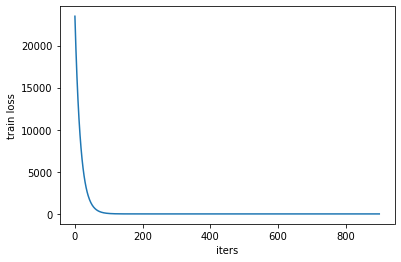

In [3]:
class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size
        
    @staticmethod
    def sigmoid(pred):
        return 1.0 / (1 + np.exp(-pred))
    
    def calculate_loss(self, y_pred, batch_X, batch_y):
        loss = -batch_y * np.log(y_pred) - (1 - batch_y) * np.log(1 - y_pred)
        return loss.sum() / batch_X.shape[0] + (self.llambda/2) * self.w.T.dot(self.w)
        
    def fit(self, X, y):
        np.random.seed(42)
        self.w = np.random.randn(X.shape[1])
        self.b = 0
        
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j+self.batch_size]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]
                
                y_pred = self.predict_proba(batch_X)
            
                # forward pass
                # <TODO> [1 point] calculate batch loss
                loss = self.calculate_loss(y_pred, batch_X, batch_y)
                dz = y_pred - batch_y
                
                # backward pass
                # <TODO> [2 points] calculate batch gradients 
                grad_w = (1 / batch_X.shape[1]) * batch_X.T.dot(dz.T) + self.llambda * self.w
                grad_b = (1 / batch_X.shape[1]) * np.sum(dz)

                # SGD optimization step
                # <TODO> [1 point]
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b

                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        pred = X.dot(self.w) + self.b
        return self.sigmoid(pred)
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
    
    
model = LogRegNumpy(llambda=3, lr=0.01, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin)))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss');

# Multinomial Logistic Regression using pytorch

In [158]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [159]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model 
        result = x @ self.W + self.b
        return result

In [160]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [161]:
class EarlyStopping:
    def __init__(self, early_stopping_patience=5):
        self.early_stopping_patience = early_stopping_patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.early_stopping_patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [162]:
def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5):
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    early_stopping = EarlyStopping(early_stopping_patience=early_stopping_patience)
    
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        early_stopping(epoch_valid_loss)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return history 

### predict hard labels [1 point]

In [163]:
def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            pred = model.forward(batch_x)
            result.append(np.argmax(pred, axis=1))
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [ ]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.1)

history = train(model, train_loader, valid_loader, 500, 2)


train loss: 3.620 valid loss:3.609



train loss: 3.571 valid loss:3.565



train loss: 3.531 valid loss:3.523



train loss: 3.492 valid loss:3.485



train loss: 3.456 valid loss:3.449



train loss: 3.419 valid loss:3.415



train loss: 3.389 valid loss:3.384



train loss: 3.359 valid loss:3.356



train loss: 3.330 valid loss:3.329



train loss: 3.307 valid loss:3.304



train loss: 3.282 valid loss:3.281



train loss: 3.260 valid loss:3.260



train loss: 3.238 valid loss:3.240



train loss: 3.222 valid loss:3.221



train loss: 3.205 valid loss:3.204



train loss: 3.187 valid loss:3.188



train loss: 3.172 valid loss:3.174



train loss: 3.158 valid loss:3.160



train loss: 3.146 valid loss:3.147



train loss: 3.136 valid loss:3.136



train loss: 3.124 valid loss:3.125



train loss: 3.113 valid loss:3.115



train loss: 3.104 valid loss:3.105



train loss: 3.095 valid loss:3.097



train loss: 3.088 valid loss:3.089



train loss: 3.080 valid loss:3.081



train loss: 3.071 valid loss:3.074



train loss: 3.065 valid loss:3.068



train loss: 3.059 valid loss:3.062



train loss: 3.053 valid loss:3.056



train loss: 3.049 valid loss:3.051



train loss: 3.045 valid loss:3.047



train loss: 3.040 valid loss:3.042



train loss: 3.036 valid loss:3.038



train loss: 3.031 valid loss:3.034



train loss: 3.027 valid loss:3.031



train loss: 3.025 valid loss:3.028



train loss: 3.022 valid loss:3.024



train loss: 3.019 valid loss:3.022



train loss: 3.016 valid loss:3.019



train loss: 3.014 valid loss:3.017



train loss: 3.011 valid loss:3.014



train loss: 3.009 valid loss:3.012



train loss: 3.008 valid loss:3.010



train loss: 3.006 valid loss:3.008



train loss: 3.003 valid loss:3.007



train loss: 3.002 valid loss:3.005



train loss: 3.001 valid loss:3.004



train loss: 3.000 valid loss:3.002



train loss: 2.999 valid loss:3.001



train loss: 2.997 valid loss:3.000



train loss: 2.996 valid loss:2.999



train loss: 2.995 valid loss:2.998



train loss: 2.994 valid loss:2.997



train loss: 2.993 valid loss:2.996



train loss: 2.992 valid loss:2.995



train loss: 2.992 valid loss:2.994



train loss: 2.991 valid loss:2.993



train loss: 2.991 valid loss:2.993



train loss: 2.990 valid loss:2.992



train loss: 2.989 valid loss:2.991



train loss: 2.989 valid loss:2.991



train loss: 2.988 valid loss:2.990



train loss: 2.988 valid loss:2.990



train loss: 2.987 valid loss:2.989



train loss: 2.987 valid loss:2.989



train loss: 2.987 valid loss:2.989



train loss: 2.986 valid loss:2.988



train loss: 2.986 valid loss:2.988



train loss: 2.986 valid loss:2.988



train loss: 2.985 valid loss:2.987



train loss: 2.985 valid loss:2.987



train loss: 2.985 valid loss:2.987


In [ ]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [168]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

0.12652681890600107

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

### What is the accuracy of constant prediction classifier for this task? [0.5 point]